In [1]:
real_password = "Twingear4!"
real_header = {
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.102 Safari/537.36 Edg/104.0.1293.70',
}

In [2]:
import mysql.connector
import sqlite3
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

CIK = ''
file_number = ''
count_cik = 0
count_file = 0
breaker = False
total = 0.0
same = False
exists = False
percent = 0.0
data_list = []
pass_variable = real_password
# establishes a user-agent to prevent a 404
header = real_header

In [3]:
# drops table of entries if it exists
db_drop_table = mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading" )
cursor_drop_table = db_drop_table.cursor()
cursor_drop_table.execute(fr"DROP TABLE IF EXISTS investments")
db_drop_table.commit()
# creates table of entries if it does not exist
db_create_table = mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading" )
cursor_create_table = db_create_table.cursor()
cursor_create_table.execute(fr"CREATE TABLE investments (TradeID INT AUTO_INCREMENT, CompanyName varchar(255), Value int, Share int, SafeInvestment TINYINT, CIK int, PRIMARY KEY (TradeID), FOREIGN KEY (CIK) REFERENCES investors(CIK))")
db_create_table.commit()

db =mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading")
cursor = db.cursor()
# retrieve hedge fund manager and asset manager data from database
cursor.execute("SELECT * FROM investors")



# iterates through each table row to retrieve the CIK number for each company filings
for row in cursor:
    breaker = False
    count_cik = 0
    count_file = 0
    CIK = row[0]
    db_name = row[1]
    # reformats the company name to be compliant with SQL syntax
    db_name = db_name.replace(" ", "_")
    # creates a URL with the current CIK number 
    cik_url = fr"https://www.sec.gov/Archives/edgar/data/{CIK}"
    # creates a connection with the Edgar database
    response_cik = requests.get(url = cik_url, headers = header)
    # verifies the success of the connection
    print(response_cik.status_code)
    print(response_cik.url)
    # creates a Beautiful Soup object with the web page content in xml format
    soup_cik = BeautifulSoup(response_cik.content, 'lxml')
    # creates a dictionary of all table content in the BS object
    soup_dic_cik = soup_cik.find_all('td')

    # parses each table line to get each file number from the table
    for line_cik in soup_dic_cik:
        # checks if a loop breaker was triggered from a lower nested for loop meaning the most recent f-13 filing was found
        if breaker == True:
            break
        # counts each line for later parsing purposes
        count_cik = count_cik + 1
        # converts BS object to string for parsing
        string_version_lc = str(line_cik)
        # checks counter and uses modulus to only parse lines that contain file names
        if count_cik == 1 or count_cik % 3 == 1:
            # parses line down to the file name and adds it to new URL
            first_split_cik = string_version_lc.split("/")
            second_split_cik = first_split_cik[5].split("\"")
            file_number = second_split_cik[0]
            file_url = fr"https://www.sec.gov/Archives/edgar/data/{CIK}/{file_number}"
            response_file = requests.get(url = file_url, headers = header)
            print(response_file.status_code)
            print(response_file.url)
            # creates new BS object with new page
            soup_file = BeautifulSoup(response_file.content, 'lxml')
            soup_dic_file = soup_file.find_all('td')
            
            # parses each line in table to find xml files
            for line_file in soup_dic_file:
                count_file = count_file + 1
                string_version_lf = str(line_file)
            
                # checks only lines that would have file names
                if count_file == 1 or count_file % 3 == 1:
                    # checks for xml file
                    find_xml = string_version_lf.find('xml')
                    # excludes unwanted xml files
                    find_doc4 = string_version_lf.find('doc4.xml')
                    find_primary_doc = string_version_lf.find('primary_doc')
                    
                    # checks the type of xml file and then parses it
                    if find_xml != -1 and find_primary_doc == -1 and find_doc4 == -1:
                        first_split_file = string_version_lf.split(">")
                        second_split_file = first_split_file[3].split("<")
                        xml_file = second_split_file[0]
                        # adds xml file to URL
                        url_xml = fr"https://www.sec.gov/Archives/edgar/data/{CIK}/{file_number}/{xml_file}"
                        response_xml = requests.get(url = url_xml, headers = header)
                        print(response_xml.status_code)
                        print(response_xml.url)
                        soup_xml = BeautifulSoup(response_xml.content, 'lxml')
                        string_version_xml = str(soup_xml)
                        # looks for 13-f file
                        thirteen_f = string_version_xml.find('thirteenf')
                        
                        # if file is an 13-f file breaks two inner loops and goes to the next company
                        if thirteen_f != -1:
                            breaker = True
                            url_13f = url_xml
                            response_13f = requests.get(url = url_13f, headers = header)
                            soup_13f = BeautifulSoup(response_13f.content, 'xml')
                            # creates a BS object of all info tables in the 13-f file
                            entries = soup_13f.find_all('infoTable')
                            dic_list = []
                            
                            # creates a dictionary of values for each entry of investments
                            for entry in entries:
                                entry_dic = {}
                                entry_dic['nameOfIssuer'] = entry.find('nameOfIssuer').text
                                entry_dic['titleOfClass'] = entry.find('titleOfClass').text
                                entry_dic['cusip'] = entry.find('cusip').text
                                entry_dic['sshPrnamt'] = entry.find('sshPrnamt').text
                                entry_dic['sshPrnamtType'] = entry.find('sshPrnamtType').text
                                entry_dic['investmentDiscretion'] = entry.find('investmentDiscretion').text
                                if entry.find('otherManager') != None:
                                    entry_dic['otherManager'] = entry.find('otherManager').text
                                entry_dic['value'] = entry.find('value').text
                                entry_dic['Sole'] = entry.find('Sole').text
                                entry_dic['None'] = entry.find('None').text
                                # creates a list of each entry dictionary
                                dic_list.append(entry_dic)
                            
                            list_cleaned = []
                            # creates a copy of the list of dictionaries which will contained cleaned data
                            for entry_dic in dic_list:
                                dic_cleaned = {}
                                # copies the name of each issuer
                                dic_cleaned['name'] = entry_dic['nameOfIssuer']
                                # initializes numeric values to zero
                                dic_cleaned['value'] = 0
                                dic_cleaned['sshPrnamt'] = 0
                                dic_cleaned['safeInvestment'] = 0
                                dic_cleaned['CIK'] = CIK
                                list_cleaned.append(dic_cleaned)
                            
                            # compares the issuer name from each dictionary of entries to against its cloned list to remove duplicate entries
                            for entry_dic in dic_list:   
                                for dic_cleaned in list_cleaned:
                                    # checks for a identical entry from cloned list allowing for only one
                                    if entry_dic['nameOfIssuer'] == dic_cleaned['name'] and same == False:
                                        # signals that one identical entry was found
                                        same = True
                                    # checks for duplicate entries after the one expected identical entry has been marked as found
                                    elif entry_dic['nameOfIssuer'] == dic_cleaned['name'] and same == True:
                                        # deletes duplicate entry from the clean version of the list
                                        list_cleaned.remove(dic_cleaned)
                                # resets Boolean value to mark identical matches in the next iteration of the original list
                                same = False
                            
                            # adds each duplicate numeric value from the original list and stores the sum in the cleaned list
                            for dic_cleaned in list_cleaned:
                                for entry_dic in dic_list:
                                    # checks that values in both lists match
                                    if entry_dic['nameOfIssuer'] == dic_cleaned['name']:
                                        # adds numeric value to running sum in the cleaned list
                                        dic_cleaned['value'] = dic_cleaned['value'] + int(entry_dic['value'])
                                        dic_cleaned['sshPrnamt'] = dic_cleaned['sshPrnamt'] + int(entry_dic['sshPrnamt'])
                            
                            total = 0
                            # calculates the sum of all asset values for each holding
                            for dic_cleaned in list_cleaned:
                                total = total + float(dic_cleaned['value'])
                            print("\nNoteable Holdings")
                            
                            # divides each asset value by the sum of all values to get the percent of value of each holding
                            for dic_cleaned in list_cleaned:
                                percent = float(dic_cleaned['value']) / total
                                # fills table with each holding if its higher than 7.5% of the total portfolio
                                if percent >= 0.075:
                                    dic_cleaned['safeInvestment'] = 1
                                     
                                print("Invester: {0:21} Value: {1} Shares: {2}".format(dic_cleaned['name'], dic_cleaned['value'], dic_cleaned['sshPrnamt']))
                                db_fill_table = mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading" )
                                cursor_fill_table = db_fill_table.cursor()
                                df_cleaned = pd.DataFrame([dic_cleaned])
                                val_to_insert = df_cleaned.values.tolist()
                                #cursor_fill_table.executemany(fr"insert into {db_name} (CompanyName, Value, Share) values (%s, %s, %s)", val_to_insert)
                                cursor_fill_table.executemany(fr"insert into investments (CompanyName, Value, Share, SafeInvestment, CIK) values (%s, %s, %s, %s, %s)", val_to_insert)
                                db_fill_table.commit()
                            # appends saved list to a master list for analysis
                            data_list.append(list_cleaned)
                            break
        


200
https://www.sec.gov/Archives/edgar/data/1067983
200
https://www.sec.gov/Archives/edgar/data/1067983/000095012322012275
200
https://www.sec.gov/Archives/edgar/data/1067983/000095012322012275/18337.xml

Noteable Holdings
Invester: ACTIVISION BLIZZARD INC Value: 4470946 Shares: 60141866
Invester: ALLY FINL INC         Value: 834901 Shares: 30000000
Invester: AMAZON COM INC        Value: 1205258 Shares: 10666000
Invester: AMERICAN EXPRESS CO   Value: 20453800 Shares: 151610700
Invester: APPLE INC             Value: 123661679 Shares: 894802319
Invester: BANK AMER CORP        Value: 30505039 Shares: 1010100606
Invester: BANK OF NEW YORK MELLON CORP Value: 2396364 Shares: 62210878
Invester: CELANESE CORP DEL     Value: 877219 Shares: 9710183
Invester: CHARTER COMMUNICATIONS INC N Value: 1161509 Shares: 3828941
Invester: CHEVRON CORP NEW      Value: 23757173 Shares: 165359318
Invester: CITIGROUP INC         Value: 2298341 Shares: 55155797
Invester: COCA COLA CO          Value: 22407999 Sha

C:\Users\iprut\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(



Noteable Holdings
Invester: 8X8 INC NEW           Value: 7476 Shares: 2166968
Invester: ALPHABET INC          Value: 523558 Shares: 5473688
Invester: ALTC ACQUISITION CORP Value: 39040 Shares: 4000000
Invester: ALTIMETER GROWTH CORP 2 Value: 13452 Shares: 1357450
Invester: AMAZON COM INC        Value: 302326 Shares: 2675450
Invester: APOLLO GLOBAL MGMT INC Value: 21058 Shares: 452869
Invester: APPLOVIN CORP         Value: 96920 Shares: 4972813
Invester: ATLASSIAN CORP PLC    Value: 362742 Shares: 1722503
Invester: ATRENEW INC           Value: 33054 Shares: 14371218
Invester: BLEND LABS INC        Value: 13727 Shares: 6211142
Invester: BLOCK INC             Value: 208922 Shares: 3799271
Invester: COINBASE GLOBAL INC   Value: 9773 Shares: 151536
Invester: CROWDSTRIKE HLDGS INC Value: 148329 Shares: 900000
Invester: DATADOG INC           Value: 512707 Shares: 5775031
Invester: DINGDONG CAYMAN LTD   Value: 422 Shares: 118539
Invester: DLOCAL LTD            Value: 88087 Shares: 4292759
Inv

In [4]:
db_investments = mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading")
cursor_investments = db_investments.cursor()
# retrieve hedge fund manager and asset manager data from database
cursor_investments.execute("SELECT CompanyName, Value, Share, CIK FROM investments")
    
db_safe_investments = mysql.connector.connect(host = "localhost", user = "root", password = pass_variable, database = "CCTrading")
cursor_safe_investments = db_safe_investments.cursor()
# retrieve hedge fund manager and asset manager data from database
cursor_safe_investments.execute("SELECT * FROM investments WHERE SafeInvestment = 1")

print('Investments:')
for row in cursor_investments:
    print(row)

print('\nSafe Investments:')
for row in cursor_safe_investments:
    print(row)

Investments:
('ACTIVISION BLIZZARD INC', 4470946, 60141866, 1067983)
('ALLY FINL INC', 834901, 30000000, 1067983)
('AMAZON COM INC', 1205258, 10666000, 1067983)
('AMERICAN EXPRESS CO', 20453800, 151610700, 1067983)
('APPLE INC', 123661679, 894802319, 1067983)
('BANK AMER CORP', 30505039, 1010100606, 1067983)
('BANK OF NEW YORK MELLON CORP', 2396364, 62210878, 1067983)
('CELANESE CORP DEL', 877219, 9710183, 1067983)
('CHARTER COMMUNICATIONS INC N', 1161509, 3828941, 1067983)
('CHEVRON CORP NEW', 23757173, 165359318, 1067983)
('CITIGROUP INC', 2298341, 55155797, 1067983)
('COCA COLA CO', 22407999, 400000000, 1067983)
('DAVITA INC', 2987630, 36095570, 1067983)
('FLOOR & DECOR HLDGS INC', 335843, 4780000, 1067983)
('GENERAL MTRS CO', 1604500, 50000000, 1067983)
('GLOBE LIFE INC', 633467, 6353727, 1067983)
('HP INC', 2603542, 104476035, 1067983)
('JEFFERIES FINL GROUP INC', 12790, 433558, 1067983)
('JOHNSON & JOHNSON', 53435, 327100, 1067983)
('KRAFT HEINZ CO', 10859921, 325634818, 1067983)

In [5]:
concatenated_data_list = []
quant_values = []

# iterates through the list of each managers lists of dictionaries of entries
for list_cleaned in data_list:
    # iterates through each dictionary in each list of dictionaries
    for dic_cleaned in list_cleaned:
        # concatenates each dictionary into one big list of entries for analysis
        concatenated_data_list.append(dic_cleaned)

# converts the list into a data frame
data_frame = pd.DataFrame.from_dict(concatenated_data_list)
# reduces the data to just the relevant numeric values
quant_values = data_frame[['value','sshPrnamt']]

    
    

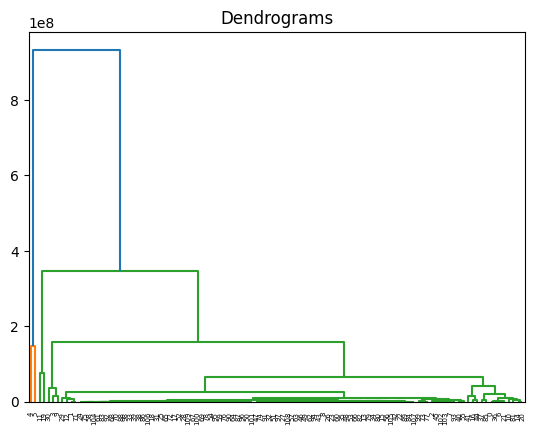

In [6]:
# creates a graph dendrogram of the hierarchical clusters of the data
graph_data = hierarchy.linkage(quant_values, method='average')
# displays graph with a title
plt.figure()
plt.title("Dendrograms")
dendrogram = hierarchy.dendrogram(graph_data)


<AxesSubplot: >

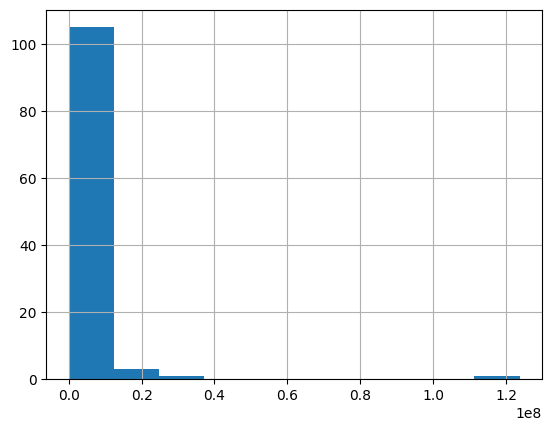

In [7]:
# creates a histogram of the data
data_frame.value.hist()